# **Job Placement Predictor**

**Submitted by Group 33**  
- Ashmit Gupta  
- Jolin Lin  
- Shikha Rajesh  
- Siddhanth Duggal  
- Yu Chang 47945050

**The University of British Columbia**  
**STAT 301**  
**Instructor**: Dr. Gabriela Cohen Freue  
**Date**: 2025/04/10


# 1. Introduction

Start with relevant background information on the topic to prepare those unfamiliar for the rest of your proposal. Motivate the question you are about to add.

Formulate one or two questions for investigation indicating if the primary goal is inference or prediction. Make sure that the question(s) can be answer with the data available. For example, you won't be able to quantify the "effect of X on Y" or "the influence of X on Y" or "how X affects Y" using the methods learned in class and observational data.

If available, align your question/objectives with the existing literature on the topic. You can add a reference to a scientific publication if available and listed in the References section (not mandatory). 

**Question:** How well can we build a model to accurately predict the placement status of a student based on their relavent activities and scores? 

... smt like this, as we talked with TAs

# 2. Methods and Results

### **2.1) Data**

**Data Source:** The dataset has been taken from Kaggle (https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data) updated 2 months ago by Kaggle username 'ruchikakumbhar'. It is under the 'CC0: Public Domain' License so the Kaggle user does not endorse this dataset. This also means it is freely available for us to use. The data collection method is not provided in the author's profile nor on the Kaggle dataset webpage, so we would assume it's **observational data**.

**Data Description:** The dataset contains various columns about the academic performance and the placement status (secured a job after graduation or not) of students. Notably, it has the following features:
- Number of variables: 12
- Number of observations: 10,000
- Variable Information: Included in the following table

| Variable Name               | Data Type   | Description |
|-----------------------------|------------|-------------|
| `StudentID`                 | Integer(Unique)   | Unique identifier for each student. |
| `CGPA`                      | Numeric    | Cumulative Grade Point Average of the student.This is an important variable because generally speaking Higher CGPA generally indicates better academic performance thus easier to be **placed**. |
| `Internships`               | Integer   | Number of internships a student has completed, which provides industry exposure. Can be 0,1, or 2 |
| `Projects`                  | Integer    | Number of academic or personal projects completed by the student. |
| `Workshops/Certifications`  | Integer    | Number of online workshops or certifications undertaken to enhance skills. |
| `AptitudeTestScore`         | Integer    | Score obtained in an aptitude test (part of recruitment) that evaluates logical reasoning and quantitative skills. |
| `SoftSkillsRating`          | Numeric    | Rating of soft skills (e.g., communication) on a scale. |
| `ExtracurricularActivities` | Categorical (Yes/No) | Indicates whether the student has participated in extracurricular activities. This provides insight into an individual's personality and engagement beyond academics. |
| `PlacementTraining`         | Categorical (Yes/No) | Specifies if the student has undergone placement training at the institution. |
| `SSC_Marks`                 | Numeric    | Marks obtained in Senior Secondary Certificate (10th-grade equivalent). |
| `HSC_Marks`                 | Numeric    | Marks obtained in Higher Secondary Certificate (12th-grade equivalent). |
| `PlacementStatus`           | Categorical (Placed/Not Placed) | **Target Variable**: Indicates whether the student was placed in a job or not. |

### **Citation**
Kumbhar, R. (n.d.). *Placement Prediction Dataset*. Kaggle. Retrieved from [https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data](https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data)

### **Data Loading**

In [84]:
# install.packages("readr")
# install.packages("knitr") 
# install.packages("dplyr")
# install.packages("broom")
# install.packages("corrr")
# install.packages("car")
# install.packages("tidyverse")
# install.packages("readr")
# install.packages("gridExtra")
# install.packages("leaps")
# install.packages("corrplot")
# install.packages("caret")

#Loading Libs
library(readr)
library(knitr)
library(dplyr)
library(broom)
library(corrr)
library(car)
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(leaps)
library(corrplot)
library(RColorBrewer)
library(dplyr)
library(caret)
library(tibble)
library(forcats)

In [85]:
data_file_link <- "https://raw.githubusercontent.com/rainn72/Placement_predictor/refs/heads/main/data/placementdata.csv"
data <- read_csv(data_file_link, show_col_types = FALSE)

num_observations <- nrow(data)
num_variables <- ncol(data)
cat("Number of observations:", num_observations, "\n")
cat("Number of variables:", num_variables, "\n")

Number of observations: 10000 
Number of variables: 12 


### **Initial Data Preprocessing**

1. we checked if there're duplicated values in the dataset and there are no duplicates that we need to remove.

In [86]:
duplicate_values <- data %>% 
                    group_by(StudentID) %>% 
                    summarise(value_count = n()) %>%
                    filter(value_count > 1)
                    
duplicate_values

StudentID,value_count
<dbl>,<int>


2. We dropped the variable `StudentID` from out dataset with the following reasons:

* **No Predictive Power:** It is simply a unique identifier assigned to each observation (each student). It's not correlated with the student's academic performance. Therefore, it does not help the model distinguish between students who are placed and those who are not.
* **Simplicity and Clarity:** Excluding irrelevant variables like IDs keeps our dataset cleaner and our model more interpretable.


In [87]:
data <- data %>% select(-StudentID)

3. We changed the name of a covariate because it("/") may raise errors in some following code

In [88]:
names(data)[names(data) == "Workshops/Certifications"] <- "Workshops_Certifications" 

head(data, 3)

unique(data$Workshops_Certifications)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced


[1] 1 2 0 3

4. We replaced the levels `NotPlaced` and `Placed` for `PlacementStatus` in the dataset with the numerical values `1` and `0`

In [89]:
data <- data %>%
  mutate(PlacementStatus = if_else(PlacementStatus == "Placed", 1, 0))

5. Convert the Yes/No columns (categorical) to factors, and we treat the covariates like `Internships` or `projects` as numeric, which assumes a linear effect between each 'level'.

In [90]:
data$ExtracurricularActivities <- factor(data$ExtracurricularActivities,
                                         levels = c("No", "Yes"))
data$PlacementTraining <- factor(data$PlacementTraining,
                                 levels = c("No", "Yes"))


head(data,3)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
7.5,1,1,1,65,4.4,No,No,61,79,0
8.9,0,3,2,90,4.0,Yes,Yes,78,82,1
7.3,1,2,2,82,4.8,Yes,No,79,80,0


### **2.2) Exploratory Data Analysis**

#### **Data Preprocessing**


##### **Check Missing Values**

In [91]:
colSums(is.na(data))

CGPA               Internships                  Projects 
                        0                         0                         0 
 Workshops_Certifications         AptitudeTestScore          SoftSkillsRating 
                        0                         0                         0 
ExtracurricularActivities         PlacementTraining                 SSC_Marks 
                        0                         0                         0 
                HSC_Marks           PlacementStatus 
                        0                         0

Good! The dataset contains no missing values.

##### **Check Class Imbalance**

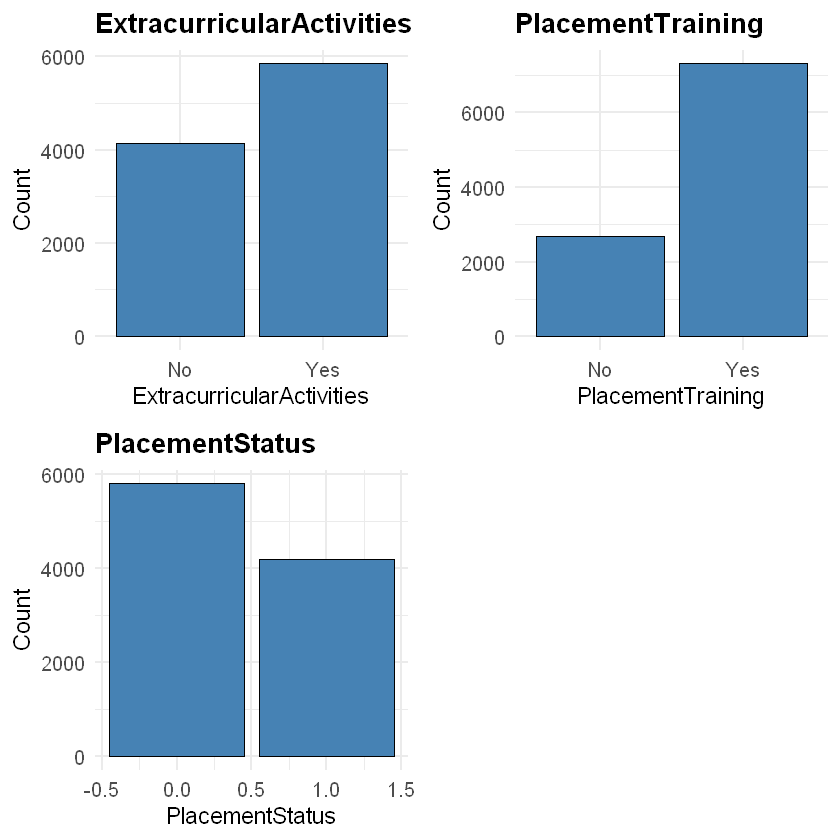

In [92]:
categorical_columns <- c("ExtracurricularActivities", "PlacementTraining","PlacementStatus")
plots <- list()

# Loop over each categorical variable to build a bar plot
for (cat_col in categorical_columns) {
  p <- ggplot(data = data, aes_string(x = cat_col)) +
    geom_bar(fill = "steelblue", color = "black") +
    labs(
      title = paste( cat_col),
      x = cat_col,
      y = "Count"
    ) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(size = 16, face = "bold"),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12)
    )
  plots[[cat_col]] <- p
}
grid.arrange(grobs = plots, ncol = 2)

- There are enough values in both the categorical predictor variables for each of their categories such that there is no reason to merge or drop come categories.
- For the response variable (PlacementStatus), there is no class imbalance, so no further tidying is required in this aspect.

##### **Check Distributional Skewness**

In [93]:
names(data)


[1] "CGPA"                      "Internships"              
 [3] "Projects"                  "Workshops_Certifications" 
 [5] "AptitudeTestScore"         "SoftSkillsRating"         
 [7] "ExtracurricularActivities" "PlacementTraining"        
 [9] "SSC_Marks"                 "HSC_Marks"                
[11] "PlacementStatus"

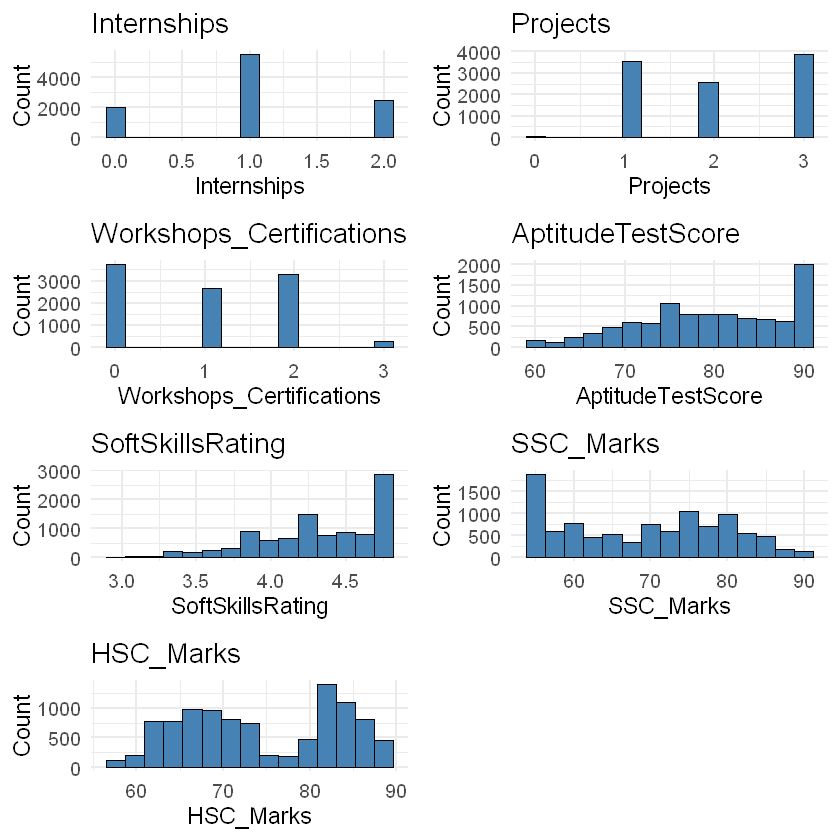

In [94]:
df_num <- c(
  "Internships", 
  "Projects", 
  "Workshops_Certifications",
  "AptitudeTestScore", 
  "SoftSkillsRating", 
  "SSC_Marks", 
  "HSC_Marks"
)

plots <- list()

for (colname in df_num) {
  p <- ggplot(data, aes_string(x = colname)) +
    geom_histogram(fill = "steelblue", color = "black", bins = 15) +  # No extra parentheses here
    labs(
      title = paste( colname),
      x = colname,
      y = "Count"
    ) +
    theme_minimal(base_size = 14)
  plots[[colname]] <- p
}

# Arrange all plots in a grid (2 columns, for example)
grid.arrange(grobs = plots, ncol = 2)


In [95]:
print(paste("The Number of Students who have Workshop Experience = 3:", 
            sum(data$Workshops_Certifications == "3")))

print(paste("The Number of Students who have Workshop Experience = 2:", 
            sum(data$Workshops_Certifications == "2")))

print(paste("---------------------------------------------------------------"))

print(paste("The Number of Students who have Project number = 1:", 
            sum(data$Projects == "1")))

print(paste("The Number of Students who have Project number = 0:", 
            sum(data$Projects == "0")))

[1] "The Number of Students who have Workshop Experience = 3: 284"
[1] "The Number of Students who have Workshop Experience = 2: 3303"
[1] "---------------------------------------------------------------"
[1] "The Number of Students who have Project number = 1: 3547"
[1] "The Number of Students who have Project number = 0: 30"


**Since there're clearly relative less people with workshop experience = 2, so we will first merge them for now**. 

In [96]:
#Pre-process Workshops
data <- data %>%
  mutate(
    Workshops_Certifications = as_factor(Workshops_Certifications),
    Workshops_Certifications = fct_collapse(
      Workshops_Certifications,
      "2+" = c("2", "3")
    )
  )
#Pre-process Projects
data <- data %>%
  mutate(
    Projects = as_factor(Projects),
    Projects = fct_collapse(
      Projects,
      "1-" = c("0", "1")
    )
  )

head(data, 3)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
7.5,1,1-,1,65,4.4,No,No,61,79,0
8.9,0,3,2+,90,4.0,Yes,Yes,78,82,1
7.3,1,2,2+,82,4.8,Yes,No,79,80,0


In [97]:
unique(data$Projects)
unique(data$Workshops_Certifications)

[1] 1- 3  2 
Levels: 1- 2 3

[1] 1  2+ 0 
Levels: 0 1 2+

By observing the plot above, I would say there is no clearly noticeable heavy skewness for other covariates that may cause problems in the logistic regression model. However, it is evident that, for example, the **AptitudeTestScore** feature has a high frequency of counts at the value of 90.


##### **Two Effective Visualizations**
- We will create a boxplot of the numerical covariates (CGPA, HSC_Marks, SSC_Marks, AptitudeTestScore, SoftSkillsRating)
- This, notably, excludes 3 numerical columns: `Internships`, `Project`s and `Workshops/Certifications`. This is because these columns have only descretised values, which are 0, 1, 2 or 3. Hence, their range, standard deviation and mean would differ a lot from the other numerical variables and thus won't look well on a single plot. Maybe in the future, we could even convert these column into 'factor' type (categorical variables) if it leads to better prediction.
- For the visualisation now, we will scale CGPA and SoftSkillsRating to be on the same scale
  - We will multiply CGPA by 10 to shift its range from 0-10 to 0-100
   - We will multiply SoftSkillsRating by 20 to shift its range 0-5 to 0-100 <br> This is done so a good comparison can be made visually by just looking at the plot.

Warning message:
"The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


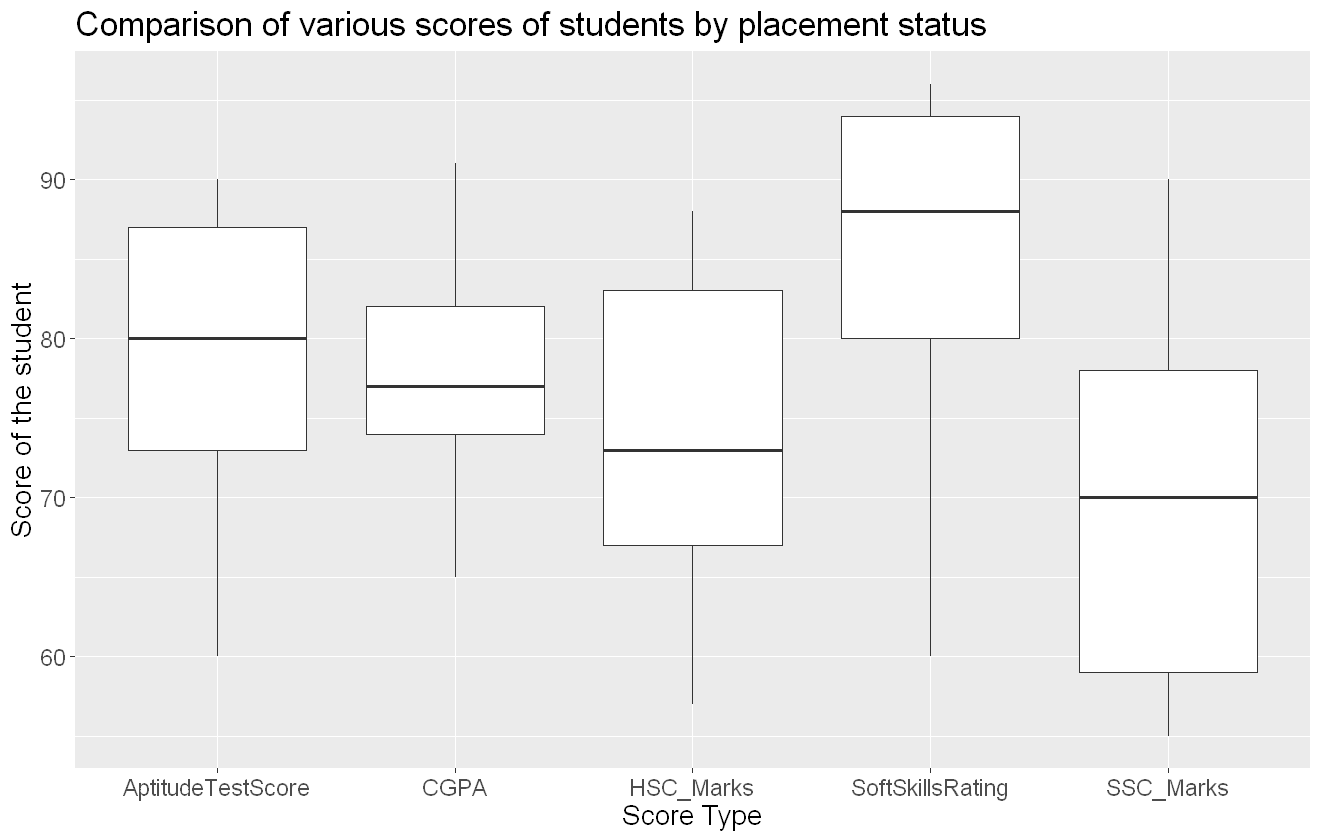

In [101]:
# Main developer: Ashmit Gupta

options(repr.plot.width = 11, repr.plot.height = 7)
marks_data <- data %>%
              mutate(CGPA = CGPA * 10, SoftSkillsRating = SoftSkillsRating * 20) %>% # Scaling CGPA and SoftSkillsRating to be from 1 to 100
              pivot_longer(cols = c(CGPA, HSC_Marks, SSC_Marks, AptitudeTestScore, SoftSkillsRating), 
                           names_to = "Score_Type", 
                           values_to = "Score")

marks_visualisation <- marks_data %>%
                       ggplot(aes(x = Score_Type, y = Score, fill = PlacementStatus)) +
                       geom_boxplot() +
                       ggtitle("Comparison of various scores of students by placement status") +
                       labs(x = "Score Type", y = "Score of the student") +
                       theme(text = element_text(size = 17))
                       
marks_visualisation

This graph is relevant to our research question as it shows the distribution of various possible predictors against the response variable (PlacementStatus). It shows that in general, the students who are placed tend to have a higher median score in the respective academic (or soft skill) category compared to the students who did not get placed.

#### Multicollinearlity
To detect whether there's a multicollinearlity issue in the independent variables, we examine it by both the correlation matrix and the variance inflation factor (VIF). 

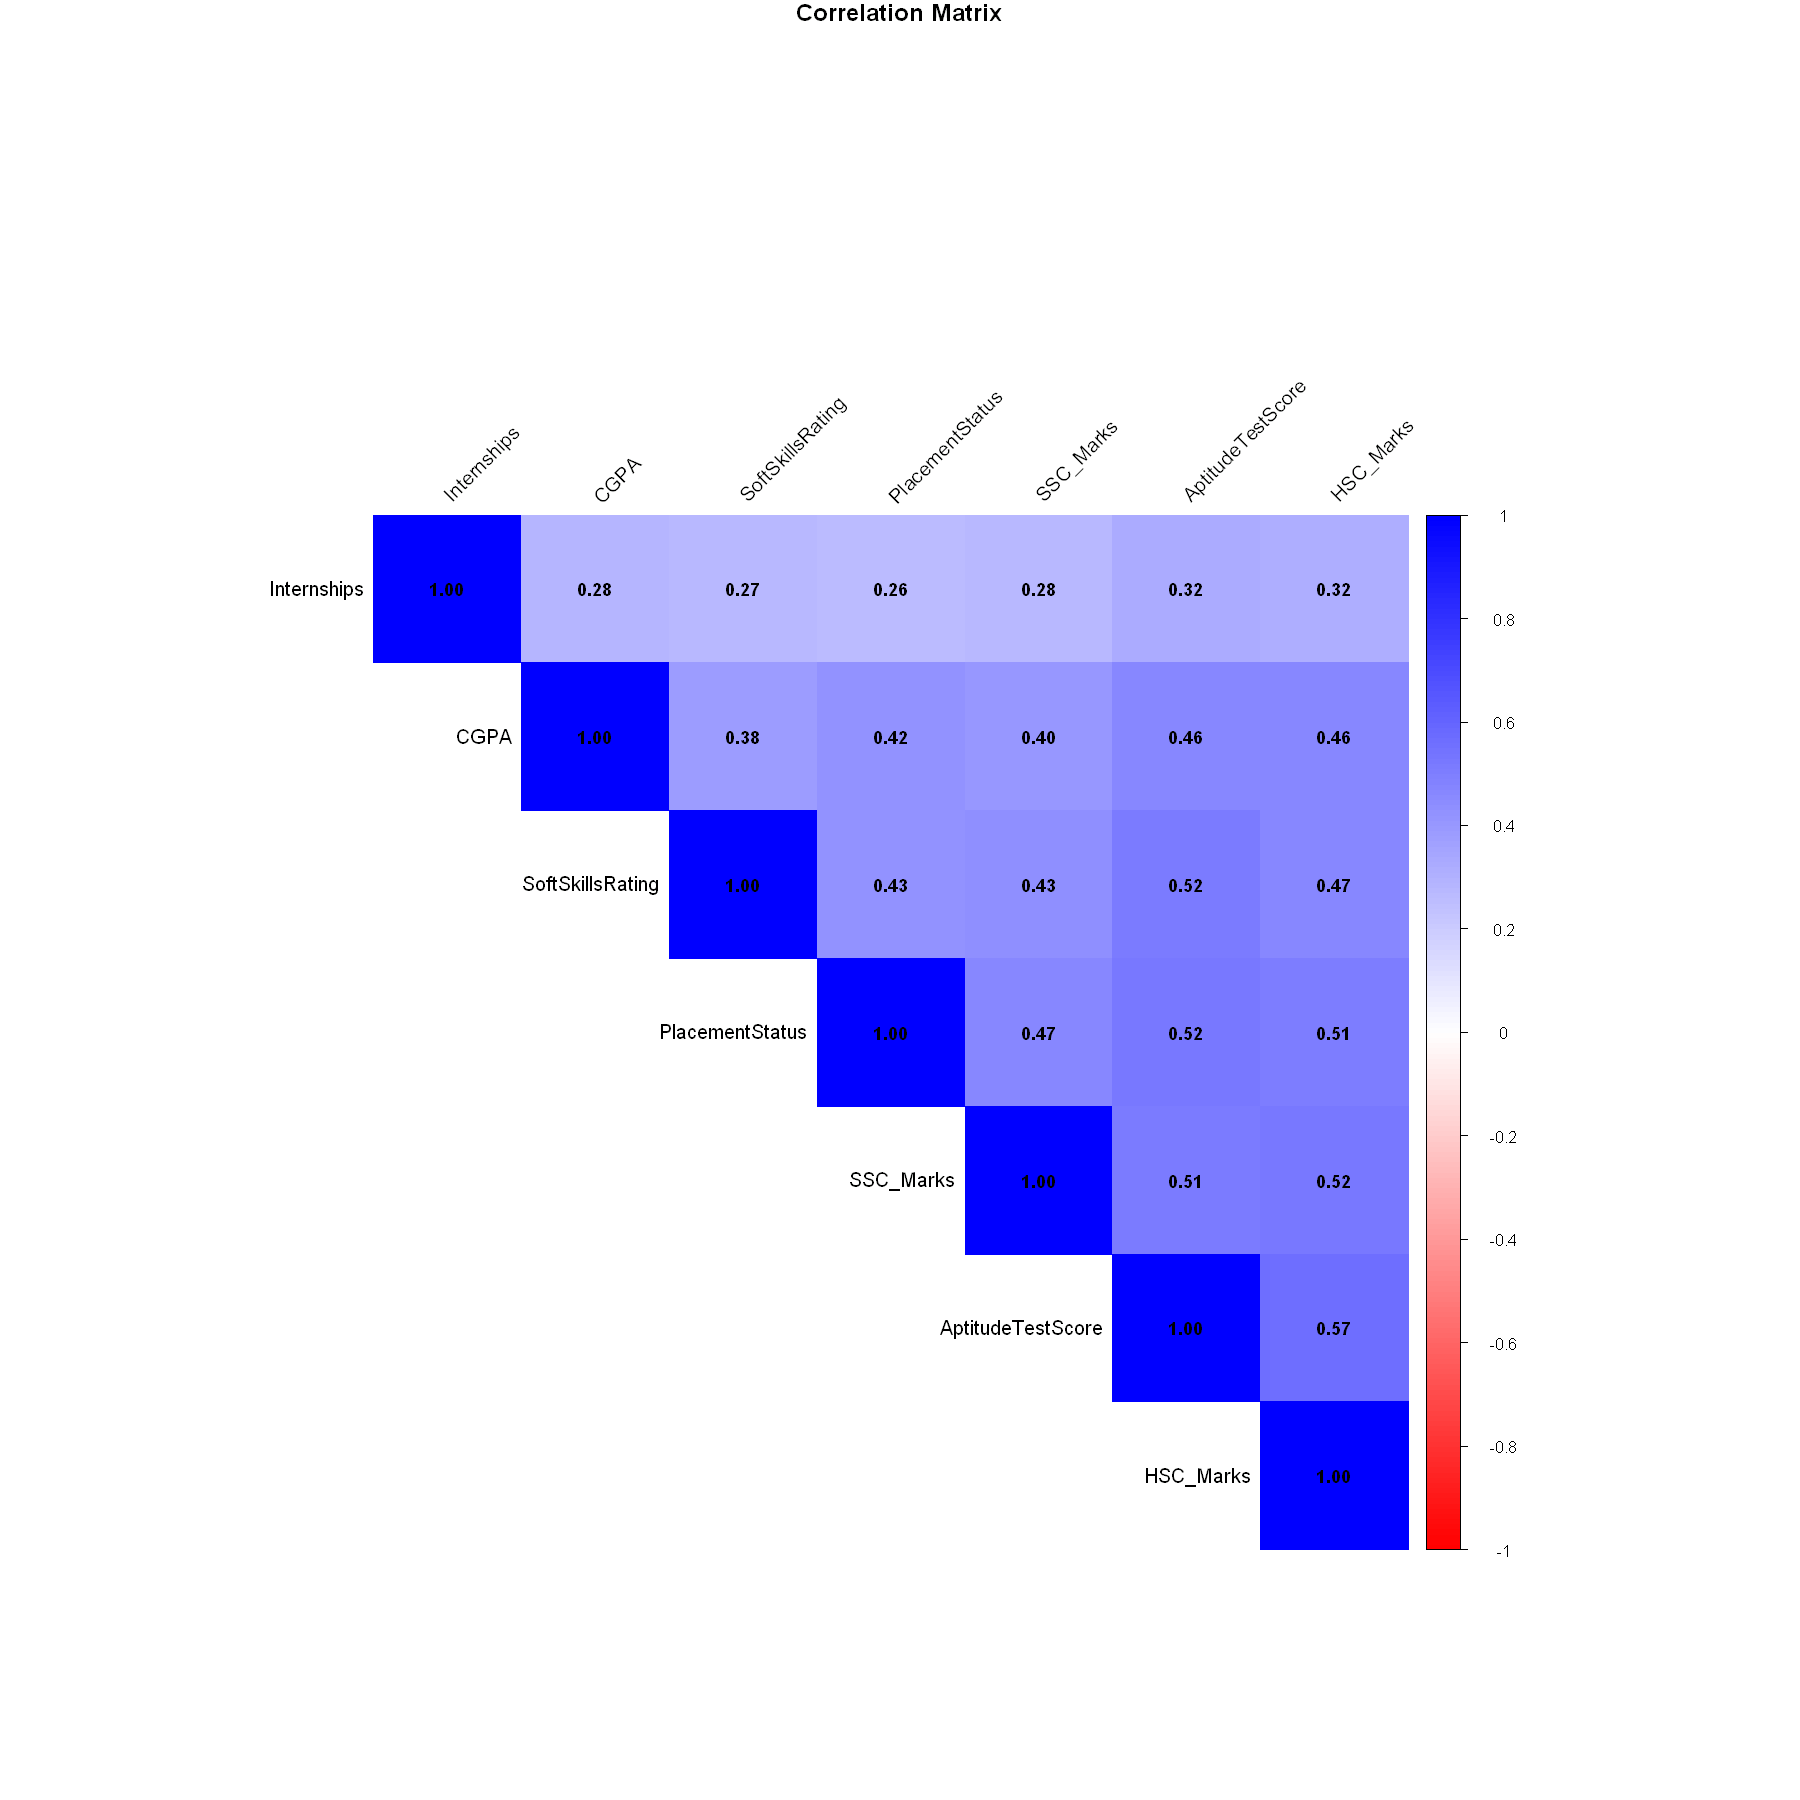

In [102]:

options(repr.plot.width = 15, repr.plot.height = 15)

numeric_data <- data %>% select_if(is.numeric)
cor_matrix <- cor(numeric_data, use = "complete.obs")

corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         tl.col = "black",
         tl.srt = 45,
         col = colorRampPalette(c("red", "white", "blue"))(200),
         title = "Correlation Matrix",
         mar = c(0,0,1,0),
         addCoef.col = "black",
         number.cex = 0.9
)


The correlation matrix heatmap indicates all pairs in continuous variables have a positive relationship, moreover, the correlation coefficient between any two pairs are lower than 0.6, suggesting no strong correlation. Therefore, multicollinearlity issue is not concerning at this stage.

Next, we will use VIF to detect whether multicollinearlity issue exist among both continuous and categorical independent variables. 

Warning message:
"glm.fit: algorithm did not converge"


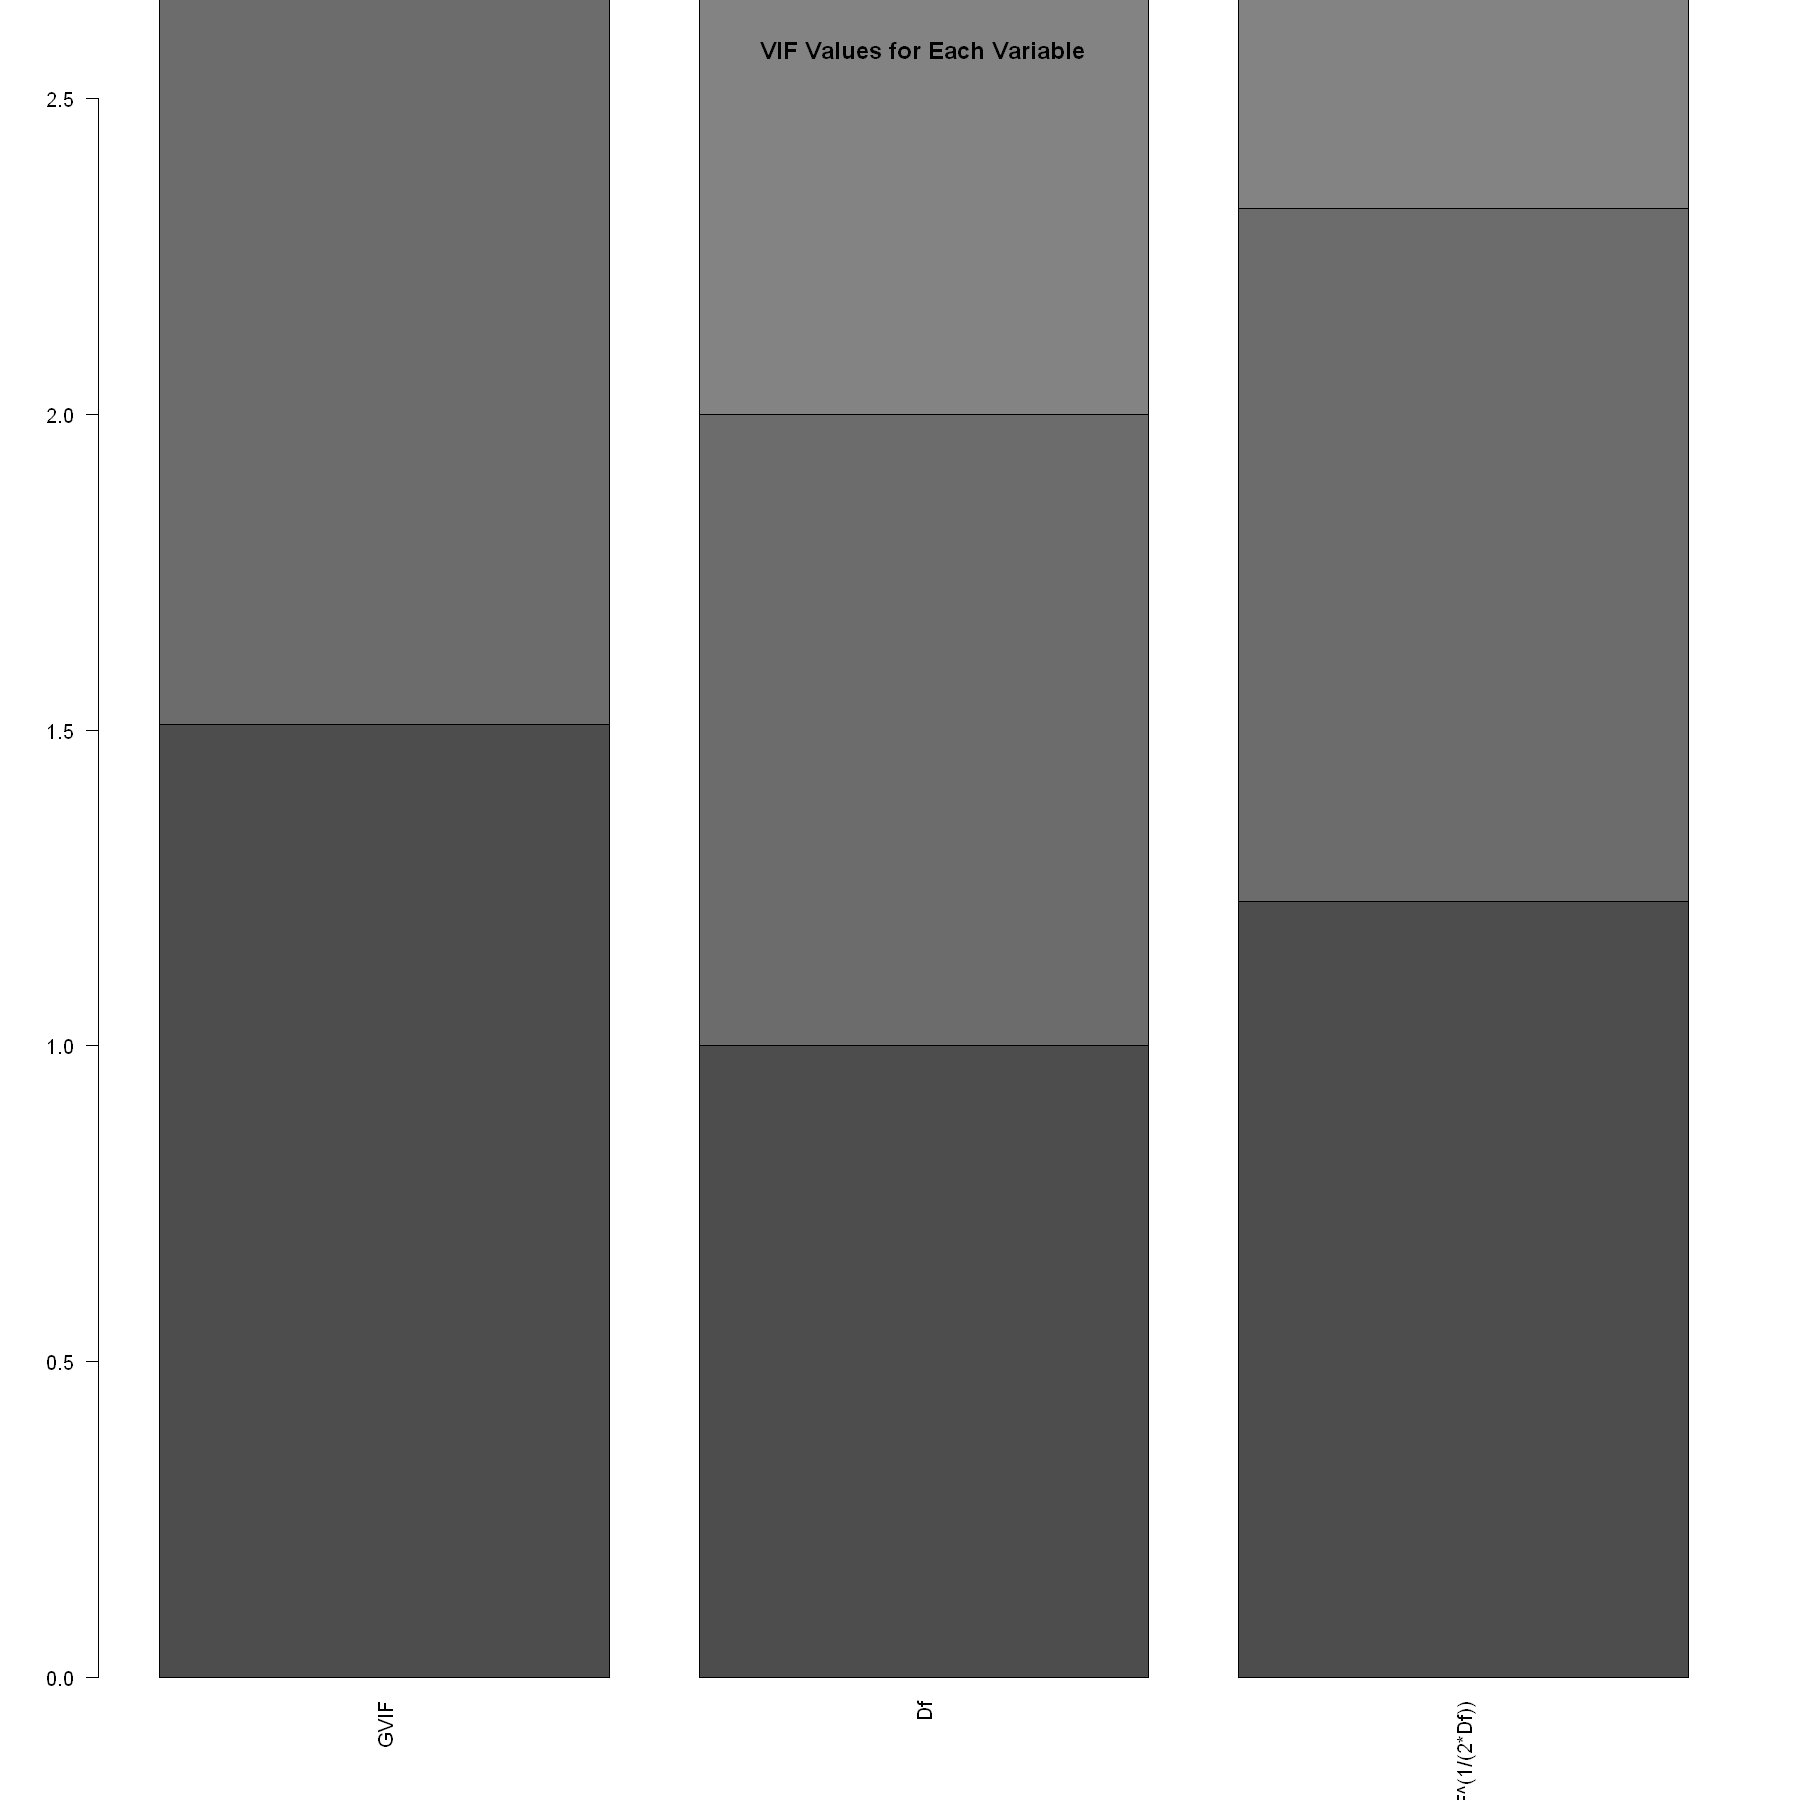

In [109]:
# Main contributor: Jolin Lin
library(dplyr)
library(car)  # for vif()

# 1) Convert or drop columns; create 0/1 target
vif_data <- data %>%
  mutate(
    EA_dummy = ifelse(ExtracurricularActivities == "Yes", 1, 0),
    PT_dummy = ifelse(PlacementTraining == "Yes", 1, 0),
    Target   = ifelse(PlacementStatus == "Placed", 1, 0)
  ) %>%
  select(-ExtracurricularActivities, -PlacementTraining, -PlacementStatus)

# 2) Fit logistic model
model_vif <- glm(Target ~ ., data = vif_data, family = "binomial")

# 3) Compute VIF
vif_value <- vif(model_vif)

# 4) Barplot with a customized y‐axis limit
max_vif <- max(vif_value)

barplot(
  vif_value,
  main      = "VIF Values for Each Variable",
  names.arg = names(vif_value),
  las       = 2,            # make labels vertical
  cex.names = 1,
  ylim      = c(0, max_vif + 0.5)  # set upper limit slightly above max
)

The VIF value for each variable are between 1 to 1.5, suggesting a low correlation between predictor variables. Same as the result concluded by correlation matrix, VIF suggests multicollinearlity issue is not concerning at this stage.

### **2.3) Methods: Plan**

#### **Method Used and Justifications**
For this prediction assignment, we propose using **Logistic Regression** to model and analyze the relationship between students' various measurements and their placement status.

#### Why is this method appropriate?
**Logistic Regression** is well-suited for binary classification problems because it models  the log-odds of the outcome as a linear function of explanatory variables. This allows us to quantify the **strength of association** between each explanatory variables and the likelihood of being placed for a job.

Also, it is easy to implement and interpret. The coefficients provide direct insight into how each covariate affects the log-odds of being placed or not, and p-values and confidence intervals (CIs) for the model coefficients are straightforward to generate. This is particularly valuable when I need to explain the model's decisions to non-technical stakeholders.

##### Which assumptions are required to apply the method selected?
* **Independence of Observations**: Each observation should be independent of the others.
* **Binary Response**: The response variable is binary.
* **Sample Size**: The sample size is large enough (which is satisfied in our case).
* **Linearity**: There should be a linear relationship between the independent variables (explanatory) and the log odds of the dependent variable (response).
* **Multicollinearity**: After data cleaning, there should be little or no multicollinearity among the independent variables.

##### Potential Limitations or Weaknesses of the Method Selected
* **Model Simplicity**: While logistic regression is straightforward, it may not capture complex non-linear relationships or interactions among variables as effectively as more advanced methods. Although it offers great interpretability, it might not provide the highest predictive accuracy compared to more complex models.
* **Outliers and Class Imbalance**: Logistic Regression is sensitive to outliers in the covariate space, which can affect the estimated coefficients and potentially skew the model's performance. Additionally, imbalanced classes may affect model performance if not addressed with appropriate techniques.


#### **Feature Selection**

## References
- Dataset has downloaded from Kaggle (https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data)
- All the information (like data description, number of variables, number of observations, variable name, variable type and variable description) in the main 'Data Description' section has been adapted from https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data